/Users/lle/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Adjusted Rand index on traning set for K-means with original data:  0.34791777716251127
Adjusted Rand index on test set for K-means with original data:  0.3492220248820656
Accuracy score on training set for K-means with original data: 0.5536833333333333
Accuracy score on test set for K-means with original data: 0.56


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 59s 980us/step - loss: 0.3438 - val_loss: 0.3081
Epoch 2/10
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3012 - val_loss: 0.2995
Epoch 3/10
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2956 - val_loss: 0.2960
Epoch 4/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.2926 - val_loss: 0.2931
Epoch 5/10
60000/60000 [==============================] - 75s 1ms/step - loss: 0.2903 - val_loss: 0.2915
Epoch 6/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.2887 - val_loss: 0.289

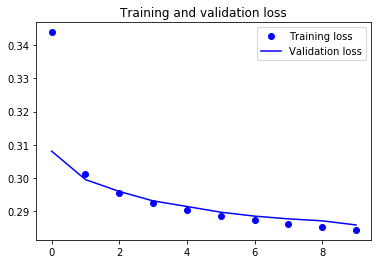



Adjusted Rand index on traning set for K-means with encoded data:  0.3609857863192329
Adjusted Rand index on test set for K-means with encoded data:  0.35362435494928274
Accuracy score on training set for K-means with encoded data: 0.5374
Accuracy score on test set for K-means with encoded data: 0.5397
Confusion Matrix on test set for K-means with encoded data: 
[[612  56   0   0  59   1 261   2   9   0]
 [ 52 915   0   0  13   0  19   0   1   0]
 [ 21   3   0   0 620   0 349   0   7   0]
 [269 610   0   0  15   0 101   0   5   0]
 [138  34   0   0 671   0 150   0   7   0]
 [  0   0   0   0   0 327   3 512   0 158]
 [196  28   0   0 362   0 395   3  16   0]
 [  0   0   0   0   0   4   0 742   0 254]
 [  3  23   0   0  70   9  64  42 785   4]
 [  1   0   0   0   0  39   1   8   1 950]]




In [1]:
# Lan Le - UB Person Number: 50322056
# CSE574 Project 3: Unsupervised Learning





import os
import util_mnist_reader
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
import keras
from keras.layers import Input,Dense,Flatten,Reshape,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from sklearn import metrics





# Extract feature values
base_dir = os.path.dirname('__file__')
fashion_file_path = os.path.join(base_dir, 'data/fashion')

X_train, y_train = util_mnist_reader.load_mnist(fashion_file_path, kind='train')
X_test, y_test = util_mnist_reader.load_mnist(fashion_file_path, kind='t10k')

# Scale input data
X_train = X_train/np.max(X_train)
X_test = X_test/np.max(X_test)

y_train = y_train + 1
y_test = y_test + 1





# K-Means Clustering with Sklearns
km = KMeans(n_clusters=10, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km_train = km.fit_predict(X_train)
y_km_test = km.predict(X_test)

# adjusted Rand index
print('Adjusted Rand index on traning set for K-means with original data: ', metrics.adjusted_rand_score(y_train, y_km_train))
print('Adjusted Rand index on test set for K-means with original data: ', metrics.adjusted_rand_score(y_test, y_km_test))

# match labels for clusters
def match_labels(k_labels, actual_labels):
    # Prep
    k_labels_matched = np.empty_like(k_labels)

    # For each cluster label...
    for k in np.unique(k_labels):

        # ...find and assign the best-matching truth label
        match_nums = [np.sum((k_labels==k)*(actual_labels==t)) for t in np.unique(actual_labels)]
        k_labels_matched[k_labels==k] = np.unique(actual_labels)[np.argmax(match_nums)]
    
    return k_labels_matched

matched_y_km_train = match_labels(y_km_train, y_train)
matched_y_km_test = match_labels(y_km_test, y_test)

# accuracy score
print('Accuracy score on training set for K-means with original data:', metrics.accuracy_score(y_train, matched_y_km_train))
print('Accuracy score on test set for K-means with original data:', metrics.accuracy_score(y_test, matched_y_km_test))

print('\n')





# Build Auto-Encoder Network with Keras library
# data preprocessing
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

# build convolutional autoencoder
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# extract encoder-only model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_1').output)

# train the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=128,
                validation_data=(X_test, X_test))

# plot the loss plot between training and validation data
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
%matplotlib inline
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
print('\n')

# save the model
autoencoder.save_weights('autoencoder.h5')





# K-Means clustering with Auto-Encoder
# get output from encoder-only model
X_encode_train = encoder.predict(X_train)
X_encode_test = encoder.predict(X_test)

# apply K-Means clustering
km_encode = KMeans(n_clusters=10, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km_encode_train = km_encode.fit_predict(X_encode_train)
y_km_encode_test = km_encode.predict(X_encode_test)

# adjusted Rand index
print('Adjusted Rand index on traning set for K-means with encoded data: ', metrics.adjusted_rand_score(y_train, y_km_encode_train))
print('Adjusted Rand index on test set for K-means with encoded data: ', metrics.adjusted_rand_score(y_test, y_km_encode_test))

# match labels for clusters
matched_y_km_encode_train = match_labels(y_km_encode_train, y_train)
matched_y_km_encode_test = match_labels(y_km_encode_test, y_test)

# accuracy score
print('Accuracy score on training set for K-means with encoded data:', metrics.accuracy_score(y_train, matched_y_km_encode_train))
print('Accuracy score on test set for K-means with encoded data:', metrics.accuracy_score(y_test, matched_y_km_encode_test))

# confusion matrix
print('Confusion Matrix on test set for K-means with encoded data: ')
print(metrics.confusion_matrix(y_test, matched_y_km_encode_test))

print('\n')





# GMM clustering with Auto-Encoder
gmm = GMM(n_components=10)
y_gmm_train = gmm.fit_predict(X_encode_train)
y_gmm_test = gmm.predict(X_encode_test)

# match labels for clusters
matched_y_gmm_train = match_labels(y_gmm_train, y_train)
matched_y_gmm_test = match_labels(y_gmm_test, y_test)

# adjusted Rand index
print('Adjusted Rand index on traning set for GMM with encoded data: ', metrics.adjusted_rand_score(y_train, y_gmm_train))
print('Adjusted Rand index on traning set for GMM with encoded data: ', metrics.adjusted_rand_score(y_test, y_gmm_test))

# accuracy score
print('Accuracy score on training set for GMM with encoded data:', metrics.accuracy_score(y_train, matched_y_gmm_train))
print('Accuracy score on test set for GMM with encoded data:', metrics.accuracy_score(y_test, matched_y_gmm_test))

# confusion matrix
print('Confusion Matrix on test set for GMM with encoded data: ')
print(metrics.confusion_matrix(y_test, matched_y_gmm_test))
